# 因果デジタルツイン

このノートブックではBottomUpParceLiNGAMモデルによる因果デジタルツインを検証する。

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score

from cdt.metrics import SHD

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from lingam.utils import make_dot as _make_dot
def make_dot(dag, labels=None):
    return _make_dot(dag, lower_limit=0, labels=labels)

from common import CausalDigitalTwin, generate_test_data, discretize, draw_hist, make_tables, draw_pred_hist

np.random.seed(1)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## 因果デジタルツインのクラス

## 1. データ生成

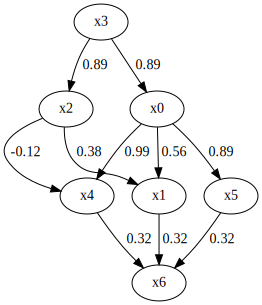

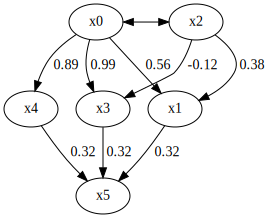

In [2]:
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
causal_order = [3, 0, 2, 1, 4, 5, 6]
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
sink_index = 6
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

display(make_dot(causal_graph_true))

# DirectLiNGAMとまったく同じなので省略

# 未観測化
delete_index = 3
causal_graph_true_unobs = causal_graph_true.copy()
causal_graph_true_unobs = np.delete(causal_graph_true_unobs, delete_index, axis=0)
causal_graph_true_unobs = np.delete(causal_graph_true_unobs, delete_index, axis=1)
causal_graph_true_unobs[0, 2] = np.nan
causal_graph_true_unobs[2, 0] = np.nan
display(make_dot(causal_graph_true_unobs))
sink_index_unobs = 5

# データ生成関数：未観測化はこの関数内で行う
def data_gen_unobs_common(causal_graph_unobs, errors):
    # 上から渡されるのはcausal_graph_unobsと未観測共通原因の誤差項を含むerror
    delete_index = 3
    
    # 未観測入りのDAGから変更点を抽出する。nanは変更点に入れない。
    a = causal_graph_true_unobs.copy()
    a[np.isnan(a)] = 0
    b = causal_graph_unobs.copy()
    b[np.isnan(b)] = 0
    pos = np.argwhere(~np.isclose(a - b, 0))
    
    #print("++++++")
    #display(pd.DataFrame(causal_graph_true_unobs))
    #display(pd.DataFrame(causal_graph_unobs))
    
    # 未観測化前の因果グラフを作成する。変更点を追加していく。
    causal_graph = causal_graph_true.copy()
    
    # 変更点を修正する
    for r, c in pos:
        # delete_indexを消しているのでdelete_index以降の番号はひとつふやす
        r = r + int(delete_index <= r)
        c = c + int(delete_index <= c)
        #print("  replacing: ", r, c, causal_graph_unobs[r, c])
        causal_graph[r, c] = causal_graph_unobs[r, c]  
    
    #display(pd.DataFrame(causal_graph))
    #print("---------")
    
    # 元の因果グラフで作って、変数を削除する。
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ errors.T).T
    X = np.delete(X, delete_index, axis=0)
    X = np.delete(X, delete_index, axis=1)
    
    # そのまま。未観測の分も誤差項がないとデータを作りようがない。
    #errors = np.delete(errors, delete_index, axis=1)
    
    return X, errors

## 2. 実験

continuous: SHD= 2.0


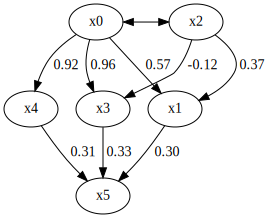

*run
before LinearRegression X_names= [0 2] , coef= [ 0.5838558  -0.05066853]
simulation LinearRegression X_names= [0 2] , coef= [ 0.59707017 -0.04027516]
before_after LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
*run shuffle
before LinearRegression X_names= [0 2] , coef= [ 0.5838558  -0.05066853]
simulation LinearRegression X_names= [0 2] , coef= [ 0.59707017 -0.04027516]
before_after LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
discrete: SHD= 6.0


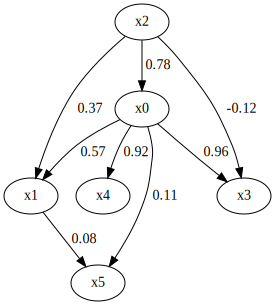

*run
before LogisticRegression X_names= [0 2] , coef= [[0.56249123 0.03113386]]
simulation LogisticRegression X_names= [0 2] , coef= [[ 4.54731181 -0.03356409]]
before_after LogisticRegression X_names= [0 2] , coef= [[0.76124832 0.02238083]]
*run shuffle
before LogisticRegression X_names= [0 2] , coef= [[ 0.67917084 -0.15175731]]
simulation LogisticRegression X_names= [0 2] , coef= [[ 4.54731181 -0.03356409]]
before_after LogisticRegression X_names= [0 2] , coef= [[0.76124832 0.02238083]]
continuous: SHD= 1.0


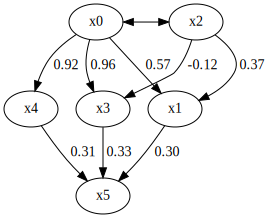

*run
before LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
simulation LinearRegression X_names= [0 2] , coef= [0.96001177 0.19222496]
before_after LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
*run shuffle
before LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
simulation LinearRegression X_names= [0 2] , coef= [0.96001177 0.19222496]
before_after LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
discrete: SHD= 3.0


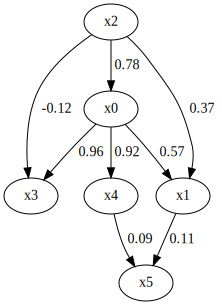

*run
before LogisticRegression X_names= [0 2] , coef= [[0.76032984 0.00101857]]
simulation LogisticRegression X_names= [0 2] , coef= [[3.52011464 1.25861275]]
before_after LogisticRegression X_names= [0 2] , coef= [[0.54366414 0.32658344]]
*run shuffle
before LogisticRegression X_names= [0 2] , coef= [[0.80164648 0.0916357 ]]
simulation LogisticRegression X_names= [0 2] , coef= [[3.52011464 1.25861275]]
before_after LogisticRegression X_names= [0 2] , coef= [[0.54366414 0.32658344]]
continuous: SHD= 0.0


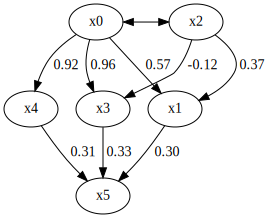

*run
before LinearRegression X_names= [0 2] , coef= [0.73413371 0.06993578]
simulation LinearRegression X_names= [0 2] , coef= [3.69486419 0.06912405]
before_after LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
*run shuffle
before LinearRegression X_names= [0 2] , coef= [0.73413371 0.06993578]
simulation LinearRegression X_names= [0 2] , coef= [3.69486419 0.06912405]
before_after LinearRegression X_names= [0 2] , coef= [0.76476226 0.06993578]
discrete: SHD= 1.0


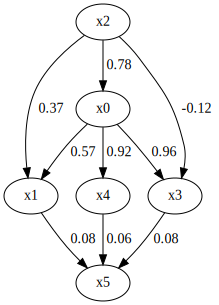

*run
before LogisticRegression X_names= [0 2] , coef= [[0.73318662 0.01983308]]
simulation LogisticRegression X_names= [0 2] , coef= [[7.8544275 0.5427431]]
before_after LogisticRegression X_names= [0 2] , coef= [[ 0.94114692 -0.08786775]]
*run shuffle
before LogisticRegression X_names= [0 2] , coef= [[ 0.76415068 -0.01884731]]
simulation LogisticRegression X_names= [0 2] , coef= [[7.8544275 0.5427431]]
before_after LogisticRegression X_names= [0 2] , coef= [[ 0.94114692 -0.08786775]]


In [3]:
# 実験間で共通のデータ

# 誤差項
error = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    error.append(np.random.uniform(-a, a, size=1000))
error = np.array(error).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 評価関数
eval_funcs_c = {"mse": mean_squared_error}
eval_funcs_d = {"precision": precision_score, "recall": recall_score}

# 離散変数
is_discrete = [False for _ in range(len(causal_graph_true_unobs))]
is_discrete[sink_index_unobs] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x2->x1, x0->x1を削除)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[1, 2] = 0
causal_graph[1, 0] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x1->x3を追加)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[3, 1] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x0->x3を10倍に設定)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[3, 0] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    cdt = CausalDigitalTwin(causal_graph_true_unobs, error, data_gen_unobs_common, sink_index_unobs, cd_algo_name="BottomUpParceLiNGAM")

    # 因果探索結果(連続)
    shd = SHD(info["modified_causal_graph"].astype(bool).astype(int), cdt._est_adj.astype(bool).astype(int), double_for_anticausal=False)
    print("continuous: SHD=", shd)
    display(make_dot(cdt._est_adj))
    
    print("*run")
    result = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"])
    
    # sinkが連続&シャッフル
    print("*run shuffle")
    result_shuffle = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    def data_gen_direct_lingam_d(causal_graph, error):
        X_d, error_ = data_gen_unobs_common(causal_graph, error)
        return discretize(X_d, sink_index_unobs), error
    cdt = CausalDigitalTwin(causal_graph_true_unobs, error, data_gen_direct_lingam_d, sink_index_unobs, is_discrete=is_discrete, cd_algo_name="BottomUpParceLiNGAM")

    # 因果探索結果(離散)
    shd = SHD(info["modified_causal_graph"].astype(bool).astype(int), cdt._est_adj.astype(bool).astype(int), double_for_anticausal=False)
    print("discrete: SHD=", shd)
    display(make_dot(cdt._est_adj))
    
    print("*run")
    result_d = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"])

    # sinkが離散&シャッフル
    print("*run shuffle")
    result_d_shuffle = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # 値はCausalDigitalTwin.run()の返り値に正解データを足したもの。 
    # 値： evals, predicted_values, simulated, X
    results[info["name"]] = {
        "continuous": result,
        "continuous_shuffle": result_shuffle,
        "discrete": result_d,
        "discrete_shuffle": result_d_shuffle,
    }

## 実験結果

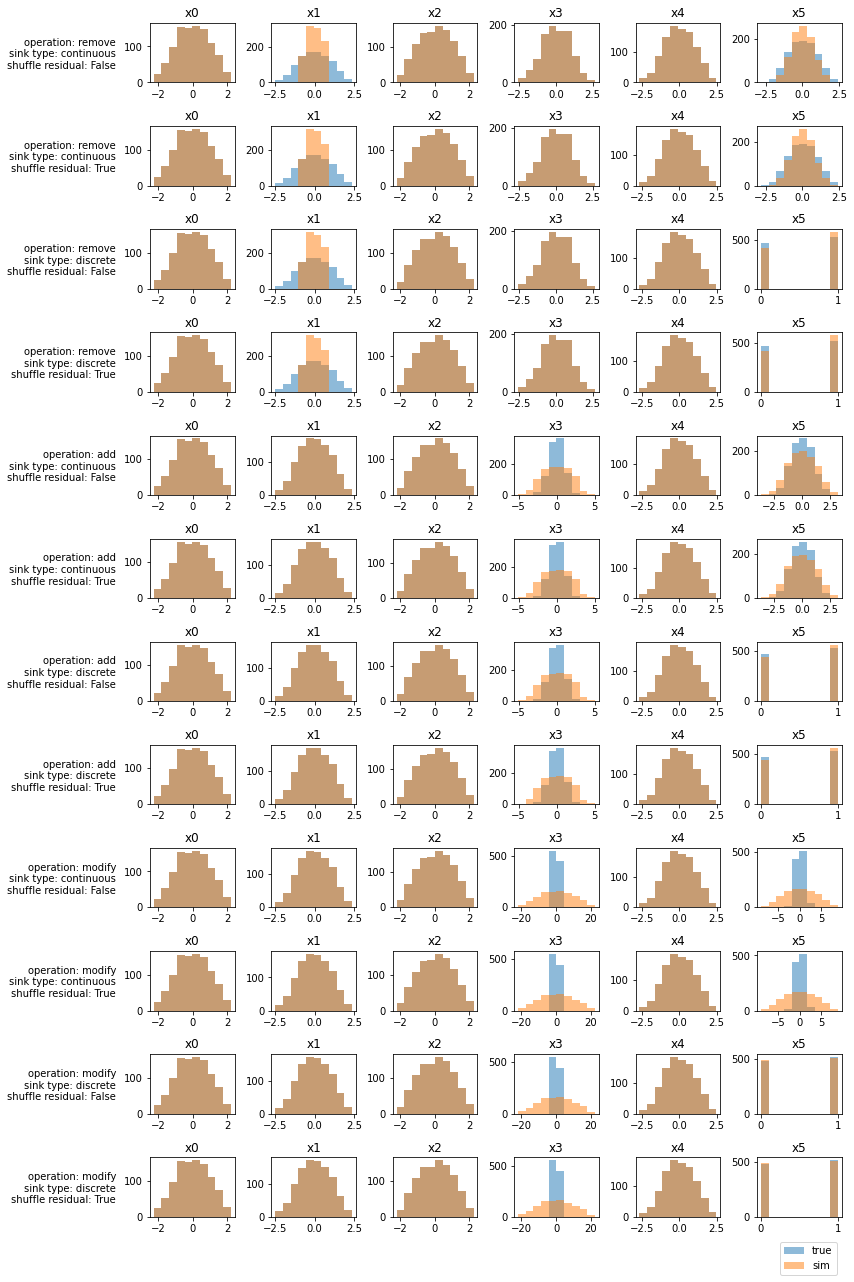

In [4]:
# 環境変化前の真のデータと環境変化後のシミュレーションデータ
n_features = len(causal_graph_true_unobs)
n_patterns = len(results) * len(results["add"])
draw_hist(n_features, n_patterns, results)

In [5]:
# シンク変数に対する機械学習モデルの精度
table_c, table_d = make_tables(results)
display(table_c.style.hide(axis="index"))
display(table_d.style.hide(axis="index"))

operation,model,shuffle error,MSE(true),MSE(sim),MSE(est)
remove,LinearRegression,False,0.258,0.258,0.334
remove,RandomForestRegressor,False,0.045,0.045,0.120
remove,LinearRegression,True,0.258,0.788,0.334
remove,RandomForestRegressor,True,0.045,0.884,0.120
add,LinearRegression,False,0.258,0.342,0.258
add,RandomForestRegressor,False,0.045,0.131,0.046
add,LinearRegression,True,0.258,2.149,0.258
add,RandomForestRegressor,True,0.045,2.282,0.045
modify,LinearRegression,False,0.258,8.372,0.259
modify,RandomForestRegressor,False,0.044,8.155,0.046


operation,model,shuffle error,Precision(true),Precision(sim),Precision(est),Recall(true),Recall(sim),Recall(est)
remove,LogisticRegression,False,0.628,0.576,0.591,0.619,0.686,0.663
remove,RandomForestClassifier,False,1.000,0.590,0.558,1.000,0.694,0.596
remove,LogisticRegression,True,0.594,0.450,0.561,0.520,0.565,0.664
remove,RandomForestClassifier,True,1.000,0.462,0.523,1.000,0.574,0.589
add,LogisticRegression,False,0.657,0.649,0.643,0.696,0.691,0.683
add,RandomForestClassifier,False,0.998,0.659,0.591,0.998,0.694,0.591
add,LogisticRegression,True,0.673,0.484,0.641,0.677,0.547,0.723
add,RandomForestClassifier,True,1.000,0.481,0.589,1.000,0.537,0.625
modify,LogisticRegression,False,0.643,0.666,0.655,0.679,0.644,0.656
modify,RandomForestClassifier,False,1.000,0.665,0.615,1.000,0.646,0.605


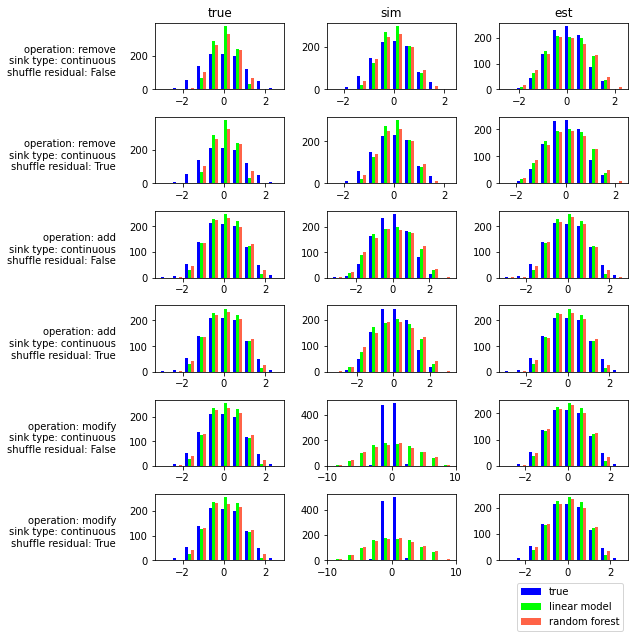

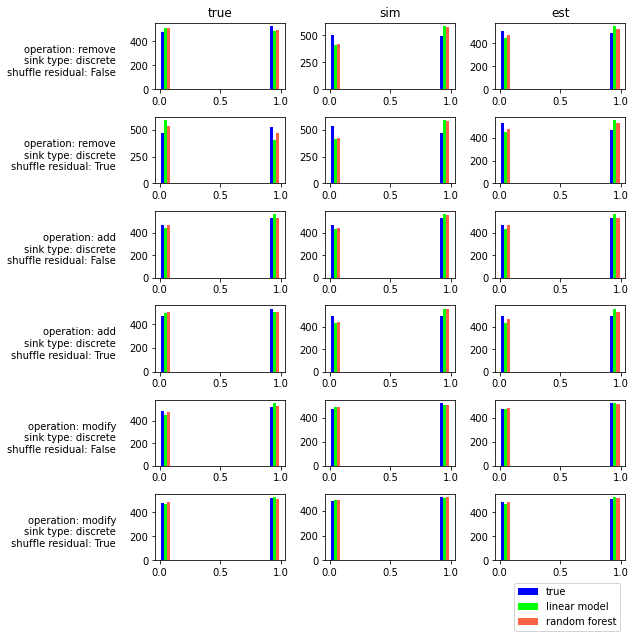

In [6]:
n_patterns = len(results) * len(results["add"])
draw_pred_hist(n_patterns, results, sink_index_unobs)